# Модель оценки стоимости автомобилей с пробегом 

## Введение

**Цель проекта**

Разработать решение, которое позволит привлечь новых пользователей для сервиса продажи авто с пробегом.

**Задача проекта**

Разработка нескольких моделей для прогноза цены автомобиля на продажу.

**Критерии качества моделей:**
- качество предсказания (значение метрики RMSE < 2500)
- время обучения модели
- время предсказания модели
____

**О данных**

**Датасет autos** содержит данные о технических характеристиках, комплектации и ценах других автомобилей.

**Признаки:** 
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)
_____

**План проекта**

Для разработки моделей будут реализованы следующие шаги.
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Корреляционный анализ
4. Обучение нескольких моделей предсказания цены
5. Анализ соответствия моделей критериям качества и выбор лучшей

Далее будет описан общий вывод.

## Импорт библиотек

In [2]:
#установим библиотеки для работы

import sys
!{sys.executable} -m pip install phik -q
!pip install lightgbm -q
!pip install catboost -q
!pip install -U scikit-learn -q

In [3]:
#импортируем библиотеки для работы

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from phik import phik_matrix

import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder 


import time

#заявим будущие константы
RANDOM_STATE = 5

## Функции для работы

In [2]:
#функция для обзора данных
def data_overview(data):
    display(data.head(10))
    print('')
    display(data.sample(10))
    print('')
    display(data.info())
    print('')
    display(data.describe().T)
    print('')
    print('')
    print('Кол-во явных дубликатов:', data.duplicated().sum())
    print('')
    print('Кол-во пропусков:')
    display(data.isna().sum())
    print('')

In [3]:
#функция для обзора дискретных признаков
def countplot_plot(column, title, y_label, x_label):
    plt.figure(figsize=(20, 6)) 
    sns.countplot(x=column, data=autos, color='#6495ED')
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.show();

In [4]:
#напишем функцию для непрерывных количественных данных
def hist_and_box_chart(column, title, y_label, x_label, bins):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"{title}", fontsize=16)
    palette = ['#87CEEB', '#4682B4', '#1E90FF', '#00BFFF', '#00CED1', '#40E0D0', '#468499', '#B0E0E6', '#66CDAA', '#6495ED']
    
    # Гистограмма
    autos[column].plot(
        kind='hist',
        alpha=0.7,
        ax=axes[0],
        color=palette[:len(column)],
        bins=bins
    )
    axes[0].set_xlabel(x_label)
    axes[0].set_ylabel(y_label)
    axes[0].set_title("Гистограмма")

    median = autos[column].median()
    mean = autos[column].mean()
    axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
    axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
    axes[0].legend()


    # Боксплот
    autos[column].plot(
        kind='box',
        ax=axes[1],
        vert=False,
        color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'}
    )
    axes[1].set_xlabel(x_label)
    axes[1].set_yticklabels([])
    axes[1].set_ylabel('')
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()

In [5]:
def countplot_plot_for_cats(column, title, y_label, x_label):
    # Считаем доли категорий
    total = len(autos)
    order = autos[column].value_counts(normalize=True).sort_values(ascending=False).index

    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
        x=column,
        data=autos,
        color='#6495ED',
        order=order
    )

    # Добавим подписи с долями над столбиками
    for p in ax.patches:
        height = p.get_height()
        percent = f'{100 * height / total:.1f}%'
        ax.annotate(
            percent,
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='bottom',
            fontsize=10, color='black'
        )

    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()


## Предобработка данных

### Импорт и обзор данных

In [6]:
#импортируем обучающие данные для модели по удовлетворенности сотрудников, тестовые входные данные и тестовые данные с целевым признаком
try:
    autos = pd.read_csv('Desktop/practicum cases/autos.csv')
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [7]:
data_overview(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
226278,2016-04-03 15:06:22,8200,sedan,2009,manual,122,1er,70000,5,petrol,bmw,no,2016-04-03 00:00:00,0,65719,2016-04-06 22:17:20
181097,2016-03-08 14:49:20,650,small,1996,manual,60,corsa,150000,6,petrol,opel,no,2016-03-08 00:00:00,0,47269,2016-03-13 02:16:34
84431,2016-03-16 11:50:00,0,NaN,1990,manual,0,golf,150000,0,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,31188,2016-03-16 11:50:00
141031,2016-03-23 10:37:35,1500,small,1999,manual,60,polo,150000,12,petrol,volkswagen,yes,2016-03-23 00:00:00,0,49134,2016-03-23 11:43:36
300317,2016-03-17 11:55:29,2200,convertible,1995,manual,150,80,150000,9,petrol,audi,no,2016-03-17 00:00:00,0,36211,2016-03-19 12:15:25
82059,2016-03-20 18:47:55,400,coupe,1992,manual,45,polo,150000,11,petrol,volkswagen,no,2016-03-20 00:00:00,0,16248,2016-03-21 22:16:44
159682,2016-03-25 12:58:16,1500,wagon,1998,manual,101,passat,150000,0,NaN,volkswagen,no,2016-03-25 00:00:00,0,4626,2016-03-25 13:40:21
336368,2016-03-29 03:36:16,1900,small,2003,manual,101,ibiza,150000,2,gasoline,seat,yes,2016-03-29 00:00:00,0,54317,2016-04-05 17:25:59
203667,2016-04-03 18:57:39,2900,small,2004,manual,54,polo,150000,5,petrol,volkswagen,NaN,2016-04-03 00:00:00,0,10555,2016-04-03 18:57:39
268090,2016-04-05 21:36:21,699,wagon,1998,manual,122,NaN,150000,10,petrol,mercedes_benz,no,2016-04-05 00:00:00,0,31134,2016-04-05 21:36:21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object

None

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0




Кол-во явных дубликатов: 4

Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Итог обзора данных**

- Названия столбцов требуют коррекции.
- Тип данных ок.
- Есть 4 явных дубликата.
- Чтобы выявить неявные дубликаты, необходимо проверить корректность заполнения в следующих столбцах:
  - тип кузова
  - тип коробки передач
  - модель
  - тип топлива
  - бренд
- Большинство статистик выглядит адекватно, однако имеются исключения:
  - Неадекватные значения в годе регистрации - как раньше 20 века, так и после 21 века.
  - Неадекватные значения в месяце регистрации (0).
  - Неадекватные значения в мощности.
  - (Предположительно) неадекватные значения в цене (0). 
- Имеется заметный объем пропущенных значений:
  - Тип кузова - около 10% пропусков.
  - Коробка передач - около 5% пропусков.
  - Модель - около 5% пропусков.
  - Тип топлива - около 10% пропусков.
  - Данные о починке - около 20% пропусков.
- Имеются столбцы с сомнительной ценностью для прогноза.
  - Столбец с числом фото несет буквально 0 информации, потому что 0 везде. Этот столбец мы удалим сразу.
  - Столбец с месяцем регистрации автомобиля никак принципиально не дополняет картину его износа (на которую указывает год регистрации), да еще и содержит неадекватные нули. Этот столбец мы также удалим сразу.
  - Столбцы с датой скачивания анкеты и датой последнего визита автора объявления в принципе отношения к вопросу не имеют. Эти столбцы мы также удалим сразу.
  - Столбец с датой создания анкеты проверим на разброс лет, чтобы понять, насколько в принципе возможно проследить влияние состояния рынка в текущий год на цену машины.
  - Столбец с почтовым индексом также проверим на разброс значений, чтобы понять, насколько в принципе возможно проследить влияние активности рынка в конкретных регионах/городах на цену машины.

### Проверка и удаление неинформативных столбцов

In [8]:
#удалим столбцы про фото, дату выгрузки анкеты, месяц регистрации авто и дату последнего визита пользователя
autos = autos.drop(columns=['NumberOfPictures', 'DateCrawled', 'RegistrationMonth', 'LastSeen'])
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,PostalCode
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00,60437


In [9]:
#проверим вариативность значений в столбце с датой создания объявлений
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'])
autos['year'] = autos['DateCreated'].dt.year
autos['year'].value_counts()

2016    354343
2015        25
2014         1
Name: year, dtype: int64

- Все объявления, кроме 26 шт, были созданы в один год. По таким данным сложно адекватно проследить влияние состояния рынка на цену авто.
- Удалим столбец, чтобы не умножать горе вычислений.

In [10]:
#удалим столбец с датой объявления
autos = autos.drop(columns=['DateCreated', 'year'])
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437


In [11]:
#проверим разброс значений в почтовых индексах
autos['PostalCode'].value_counts()

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
21782      1
9517       1
29367      1
38325      1
82404      1
Name: PostalCode, Length: 8143, dtype: int64

- В датасете на 350К строк одно и то же значение почтового индекса повторяется максимум 819 раз. По таким данным сложно адекватно проследить влияние активности рынка в конкретном регионе/городе на цену авто.
- Удалим столбец, пощадим модель.

In [12]:
#удалим столбец с датой объявления
autos = autos.drop(columns=['PostalCode'])
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Проверка очевидных выбросов

Мы рассмотрим более подробно разброс значений при исследовательском анализе, однако часть значений можно отрезать уже сейчас, чтобы график не портили.
- Автомобили с годом регистрации до 1900 года (первый автомобиль появился в 1885) и позже 2016 (крайний год создания объявлений).
- Автомобили с мощностью, превышающей 1500 лошадиных сил - это наивысшее значение для серийных автомобилей в 2016 году.

In [13]:
#удалим очевидные выбросы по дате регистрации
autos = autos.query('(RegistrationYear <= 2016) & (RegistrationYear >= 1900)').copy()
autos.query('(RegistrationYear > 2016) & (RegistrationYear < 1900)')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


In [14]:
#удалим очевидные выбросы по мощности
autos = autos.query('Power < 1500').copy()
autos.query('Power > 1500')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired


### Проверка и коррекция заполнения

In [15]:
#переименуем столбцы ручками, потому что так быстрее и точнее, чем "по-умному"
autos.rename(columns={'Price': 'price',
                      'VehicleType': 'vehicle_type',
                      'RegistrationYear': 'registration_year',
                      'Gearbox': 'gearbox',
                      'Power': 'power',
                      'Model': 'model',
                      'Kilometer': 'km',
                      'FuelType': 'fuel_type',
                      'Brand': 'brand',
                      'Repaired': 'repaired'}, inplace=True)

autos.head()

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [16]:
print(autos['vehicle_type'].value_counts())
print('')
print(autos['gearbox'].value_counts())
print('')
print(autos['model'].value_counts())
print('')
print(autos['fuel_type'].value_counts())
print('')
print(autos['brand'].value_counts())
print('')
print(autos['repaired'].value_counts())
print('')

sedan          91400
small          79795
wagon          65114
bus            28758
convertible    20195
coupe          16152
suv            11990
other           3279
Name: vehicle_type, dtype: int64

manual    257427
auto       64256
Name: gearbox, dtype: int64

golf                  27605
other                 23862
3er                   19216
polo                  12444
corsa                 11930
                      ...  
kalina                    6
serie_3                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

petrol      209896
gasoline     96262
lpg           5157
cng            540
hybrid         225
other          195
electric        89
Name: fuel_type, dtype: int64

volkswagen        73148
opel              37969
bmw               35778
mercedes_benz     30985
audi              28461
ford              24158
renault           16916
peugeot           10623
fiat               9152
seat   

In [17]:
#посмотрим на автомобили с загадочным кузовом small
autos.query('vehicle_type == "small"').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
15,450,small,1910,NaN,0,ka,5000,petrol,ford,NaN
17,1750,small,2004,auto,75,twingo,150000,petrol,renault,no
23,450,small,1997,manual,50,arosa,150000,petrol,seat,no
29,690,small,2003,manual,60,punto,150000,petrol,fiat,no
44,3900,small,2008,auto,61,fortwo,80000,petrol,smart,NaN
45,590,small,1999,manual,75,clio,125000,petrol,renault,no
62,5500,small,2010,manual,60,fabia,70000,petrol,skoda,no


In [18]:
autos.query('vehicle_type == "other"').head(20)

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
36,1600,other,1991,manual,75,kadett,70000,NaN,opel,NaN
38,11900,other,2002,manual,129,other,150000,gasoline,volkswagen,no
76,1400,other,2003,manual,82,vito,150000,gasoline,mercedes_benz,no
191,550,other,1997,manual,75,golf,150000,petrol,volkswagen,no
412,13950,other,2011,manual,140,NaN,60000,gasoline,alfa_romeo,no
433,5500,other,2010,manual,120,other,150000,gasoline,citroen,no
479,4760,other,2008,manual,98,other,150000,gasoline,peugeot,yes
607,450,other,1996,manual,0,combo,150000,gasoline,opel,NaN
792,1600,other,2001,manual,101,zafira,150000,petrol,opel,no
831,2549,other,1998,manual,150,golf,150000,petrol,volkswagen,NaN


In [19]:
#почитаем список моделей внимательно
autos['model'] = autos['model'].str.lower()
unique_models = autos['model'].unique()
unique_models = unique_models[~pd.isna(unique_models)]
sorted_unique_models = np.sort(unique_models)
sorted_unique_models

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

- Типы кузова очевидных смысловых повторов и опечаток не имеют. Примечательно наличие сразу двух категорий, которые выглядят как заглушки: большая категория small, где на деле большинство моделей чаще всего представлены типом хэтчбэк (но не всегда, и достоверно мы выяснить это не можем), и категория other, на которую приходится меньше 1%, но на деле это автомобили с типами кузова разной редкости, от универсала до фургона или кабриолета. 
- Типы коробок передач очевидных смысловых повторов и опечаток не имеют. Категорий-заглушек нет.
- Есть неявный повтор range_rover и rangerover, которые мы объединим в один range_rover. Примечательно наличие очень большой категории-заглушки other, она вторая по популярности.
- Типы топлива gasoline и petrol обозначают один и тот же вид топлива, объединим в один огромный petrol. Есть категория-заглушка other, на которую приходится всего 204 авто.
- Бренды очевидных смысловых повторов и опечаток не имеют. Категорий-заглушек нет.

In [20]:
#объединим range_rover и rangerover в range_rover'ы
autos['model'] = autos['model'].replace(['rangerover'],'range_rover')
autos.query('model == "rangerover"')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired


In [21]:
autos.query('model == "range_rover"')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
5615,14900,suv,1993,auto,182,range_rover,150000,petrol,land_rover,no
22356,2800,suv,1996,auto,224,range_rover,150000,NaN,land_rover,no
26526,5600,suv,1982,manual,125,range_rover,5000,petrol,land_rover,NaN
27949,1050,small,1998,manual,103,range_rover,150000,petrol,rover,NaN
32216,14950,suv,1994,auto,182,range_rover,150000,petrol,land_rover,no
...,...,...,...,...,...,...,...,...,...,...
331660,16995,suv,2007,auto,272,range_rover,150000,gasoline,land_rover,no
340882,1500,NaN,1995,auto,224,range_rover,150000,petrol,land_rover,NaN
344294,3500,suv,1997,manual,136,range_rover,150000,gasoline,land_rover,no
345351,10999,suv,2004,auto,286,range_rover,150000,petrol,land_rover,no


In [22]:
#объединим petrol и gasoline в petrol
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'],'petrol')
autos['fuel_type'].value_counts()

petrol      306158
lpg           5157
cng            540
hybrid         225
other          195
electric        89
Name: fuel_type, dtype: int64

### Заполнение пропусков

Сначала мы избавимся от совсем плохих случаев, когда строка имеет пропуски вообще во всех колонках, и, значит, без удаления почти все данные по строке были бы синтетическими.
______

Далее мы заполненим пропуски по следующим категориям:
- Тип кузова - около 10% пропусков - присвоим существующее значение other. Причина: заметно доминирующего значения нет, при этом структура датасета уже учитывает довольно много вариантов (хотя и не все популярные опции, чем, в частности, можно объяснить погрешности в заполнении графы), и существующая категория "разное неопределенное" в целом описывает разумные предположения на счет данных конкретных пропусков в их текущем объеме.
- Коробка передач - меньше 5% пропусков - присвоим новое значение other. Причина: в реальности типов коробок больше, чем 2, что никак не отражено в текущей структуре, и популярность конкретного типа варьируется в зависимости от года выпуска автоммобиля, поэтому значение other выглядит справедливо.
- Модель - меньше 5% пропусков - присвоим им существующее значение other. Причина: в датасете уже существует категория "разного неопределенного", поэтому множить сущности в столбце с 250 значениями еще одним "неизвестным" неразумно.
- Тип топлива - около 10% пропусков - присвоим им существующее значение petrol. Причина: бензин является самым вероятным значением и в реальности, и в рамках датасета (на это значение приходится более 95% достоверно указанных данных), даже с учетом представленности многих других типов топлива, включая уж совсем оригинальный случай other.
- Данные о починке - около 20% пропусков - присвоим новое значение unknown. Причина: число пропусков очень большое, в достоверно известных случаях соотношение 2 к 1 и утаивание факта ремонта вполне информативно само по себе.

In [23]:
#посмотрим на данные, где пропуски есть во всех 5 случаях
autos[autos['vehicle_type'].isna() & autos['fuel_type'].isna() & autos['model'].isna()&autos['repaired'].isna()&autos['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
1331,650,NaN,1970,NaN,26,NaN,100000,NaN,trabant,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


In [24]:
#попрощаемся с Опелем 1111 года регистрации и другими удивительно бесплатными авто
autos = autos.dropna(subset=['vehicle_type', 'fuel_type', 'model', 'repaired', 'gearbox'], how='all')

#проверим, как всё прошло
autos[autos['vehicle_type'].isna() & autos['fuel_type'].isna() & autos['model'].isna()&autos['repaired'].isna()&autos['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired


In [25]:
#теперь восполним пробелы согласно плану выше
autos.loc[:, 'vehicle_type'] = autos['vehicle_type'].fillna('other')
autos.loc[:, 'gearbox'] = autos['gearbox'].fillna('other')
autos.loc[:, 'model'] = autos['model'].fillna('other')
autos.loc[:, 'fuel_type'] = autos['fuel_type'].fillna('petrol')
autos.loc[:, 'repaired'] = autos['repaired'].fillna('unknown')


#проверим, как всё прошло
autos.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
km                   0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Удаление дубликатов

In [26]:
#ужаснемся обилию дубликатов
autos.duplicated().sum()

46765

In [27]:
#но всё равно удалим эти 13.5% данных, чтобы избежать переобучения и всякого
autos = autos.drop_duplicates()
autos = autos.reset_index(drop=True)

### Повторный обзор

In [28]:
data_overview(autos)

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,other,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,petrol,volkswagen,unknown


,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
83814,10990,small,2009,manual,109,cooper,40000,petrol,mini,no
185906,11500,sedan,2005,auto,163,e_klasse,125000,petrol,mercedes_benz,unknown
178000,1000,small,2001,manual,60,other,150000,petrol,volkswagen,no
31328,3150,wagon,2000,auto,150,3er,150000,petrol,bmw,no
201251,3458,other,1995,other,77,transporter,150000,petrol,volkswagen,unknown
64577,650,small,1998,manual,56,sirion,100000,petrol,daihatsu,unknown
161837,0,other,2000,manual,90,civic,150000,petrol,honda,yes
78431,2000,sedan,1997,manual,136,e_klasse,150000,petrol,mercedes_benz,no
211870,145,bus,2014,manual,75,caddy,20000,petrol,volkswagen,no
18933,100,other,1995,manual,54,golf,150000,petrol,volkswagen,yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290775 entries, 0 to 290774
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              290775 non-null  int64 
 1   vehicle_type       290775 non-null  object
 2   registration_year  290775 non-null  int64 
 3   gearbox            290775 non-null  object
 4   power              290775 non-null  int64 
 5   model              290775 non-null  object
 6   km                 290775 non-null  int64 
 7   fuel_type          290775 non-null  object
 8   brand              290775 non-null  object
 9   repaired           290775 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.2+ MB


None

,count,mean,std,min,25%,50%,75%,max
price,290775.0,4587.270188,4611.193655,0.0,1100.0,2900.0,6699.0,20000.0
registration_year,290775.0,2002.539923,7.176340,1910.0,1999.0,2003.0,2007.0,2016.0
power,290775.0,109.251720,67.110620,0.0,71.0,105.0,143.0,1436.0
km,290775.0,127058.017367,38386.683809,5000.0,125000.0,150000.0,150000.0,150000.0




Кол-во явных дубликатов: 0

Кол-во пропусков:


price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
km                   0
fuel_type            0
brand                0
repaired             0
dtype: int64

### Выводы по предварительной обработке данных

- Были удалены столбцы с датой забора анкет, датой публикации объявления, месяцем регистрации авто, числом фото, район проживания и момент последнего визита пользователя, как не имеющие ценности для модели - по причине низкой информативности в текущем виде и/или по причине отсутстивия связи с целевым значением. 
- Названия столбцов скорректированы.
- Корректность значений в столбцах с категориальными признаками проверена.
  - были объединены типы топлива gasoline и petrol, т.к. это буквально один и тот же бензин
  - был устранен неявный повтор в моделях range_rover и rangerover
- Большинство статистик выглядит адекватно, однако есть ряд значений, часть которых была обработана сразу, а часть предстоит исправить ***на этапе исследовательского анализа стоит проверить следующие значения и адекватно скорректировать их или удалить***:
  - Неадекватные значения в годе регистрации. Все значения старше 2016 года удалены, т.к. это год забора объявлений. Также были удалены автомобили с датой регистрации раньше 20 века.
  - Неадекватные значения в месяце регистрации. Столбец был удален.
  - Неадекватные значения в мощности. Были удалены все значения выше максимальной мощности серийного авто в 2016 году. Необходимо также оценить всё подробнее при исследовательском анализе.
  - (Предположительно) неадекватные значения в цене (0). Необходимо оценить при исследовательском анализе.
- В данных имелся заметный объем пропущенных значений.
  - Тип кузова - около 10% пропусков. Присвоено существующее значение other. 
  - Коробка передач - около 5% пропусков. Создано и присвоено значение other.
  - Модель - около 5% пропусков. Присвоено существующее значение other.
  - Тип топлива - около 10% пропусков. Присвоено значение-мода petrol.
  - Данные о починке - около 20% пропусков. Создано и присвоено значение unknown.
  - Были удалены данные с пропусками во всех колонках ниже, чтобы не создавать целиком синтетические строки.
- Были устранены явные и неявные дубликаты.
- Тип данных ок (будет впоследствии коррекция для определенных моделей МО).

## Исследовательский анализ данных

### Категориальные признаки

Качественные признаки в датасете:
- Тип кузова.
- Тип коробки передач.
- Модель.
- Бренд.
- Тип топлива.
- Факт ремонта за время эксплуатации.
_______

Визуализировать данные по 40 бренлам и 250 моделям мы не будем.
Посмотрим только на распределение категориальных значений с более ограниченной вариативностью.

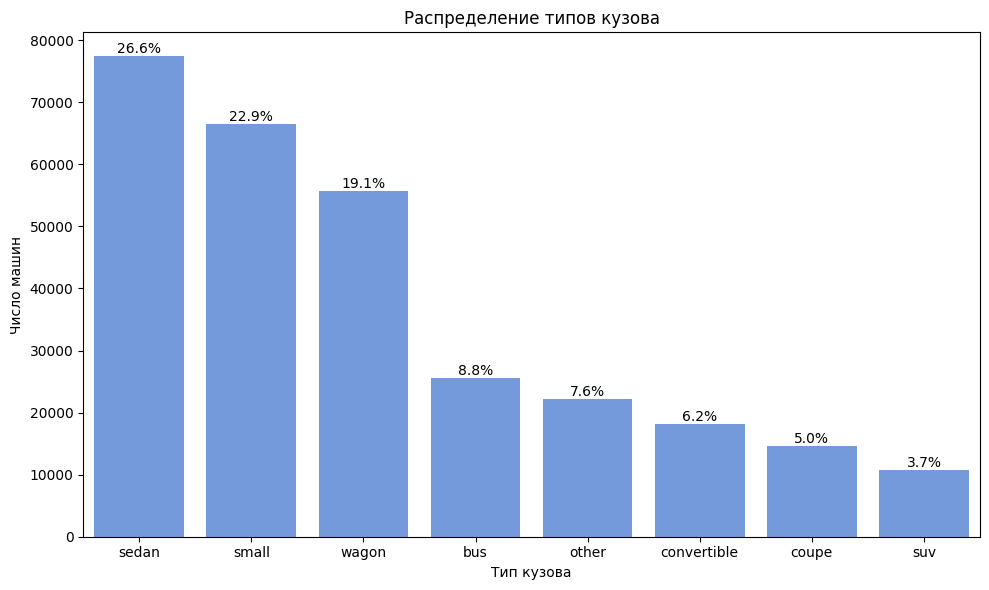

In [29]:
countplot_plot_for_cats('vehicle_type', 'Распределение типов кузова', 'Число машин', 'Тип кузова')

- 70% автомобилей в датасете - это средние автомобили: седаны, хэтчбеки и универсалы, почти в равных долях.
- В целом всё выглядит правдоподобно.

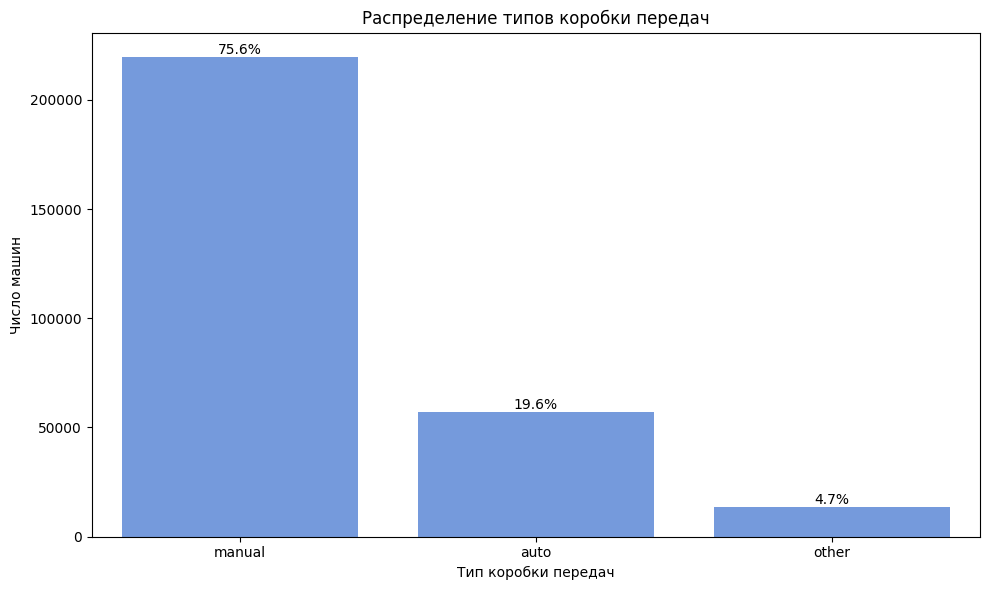

In [30]:
countplot_plot_for_cats('gearbox', 'Распределение типов коробки передач', 'Число машин', 'Тип коробки передач')

- В датасете заметен сильный перекос в сторону авто с ручной коробкой передач - 3/4 авто.
- Такой перекос указывает скорее на обилие возрастных автомобилей в датасете - более современные модели чаще имеют коробку автомат. Однако, признак не целевой, поэтому ситуация приемлема.

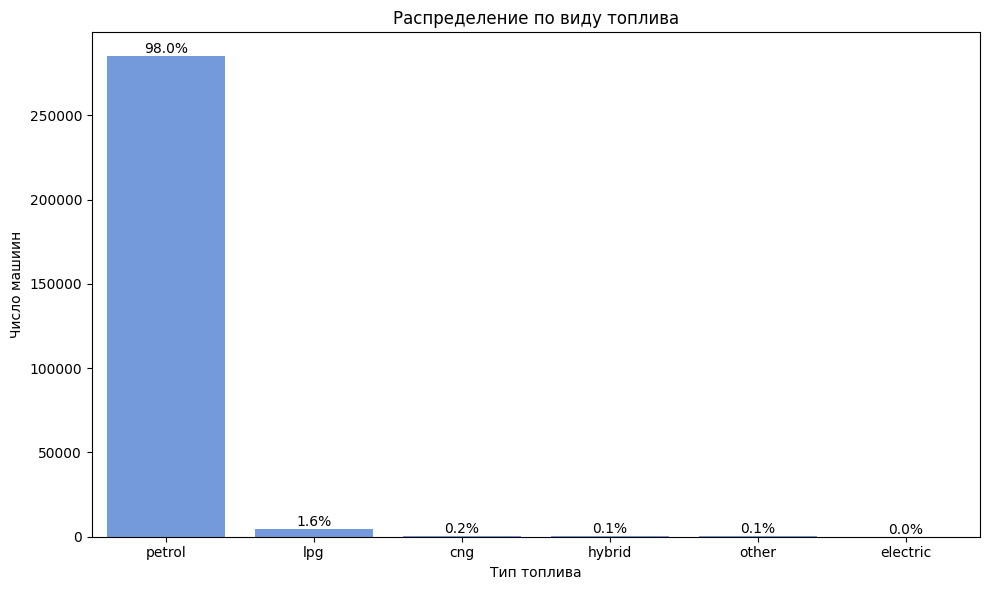

In [31]:
countplot_plot_for_cats('fuel_type', 'Распределение по виду топлива', 'Число машиин','Тип топлива')

- Этот очень красивый график демонстрирует выдающую популярность машин, работающих на бензине. В целом это актуально даже для современных авто, не говоря уж о возрастных моделях.
- В целом это малоинформативный признак.

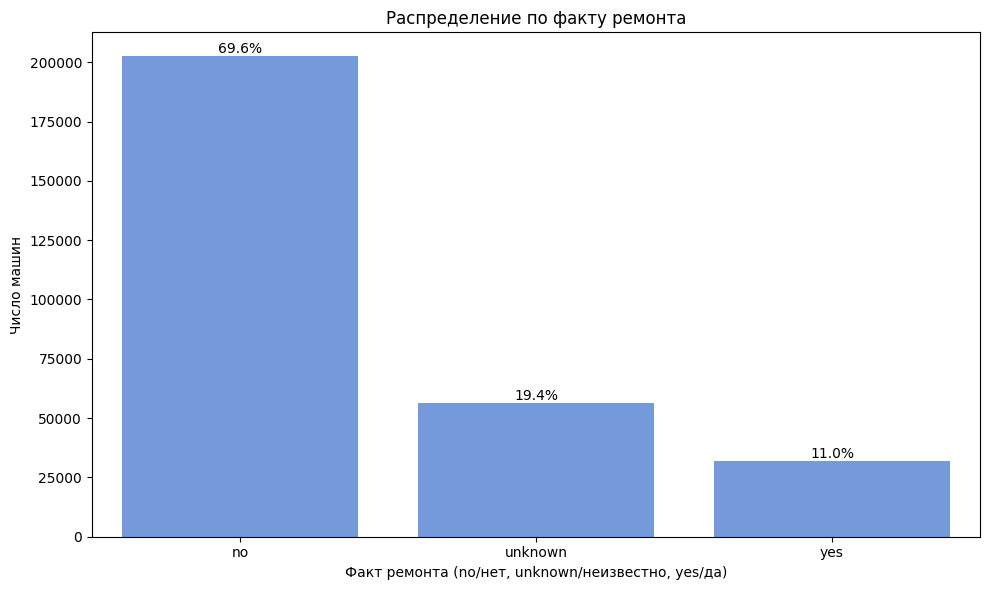

In [32]:
countplot_plot_for_cats('repaired', 'Распределение по факту ремонта', 'Число машин','Факт ремонта (no/нет, unknown/неизвестно, yes/да)')

- Почти 3/4 автомобилей вполне вероятно реально "не биты, не крашены".
- В целом всё выглядит довольно правдоподобно, может, самую малость излишне хорошо.

### Количественные признаки

Количественные признаки в датасете:
- Год регистрации
- Мощность
- Пробег
- Цена

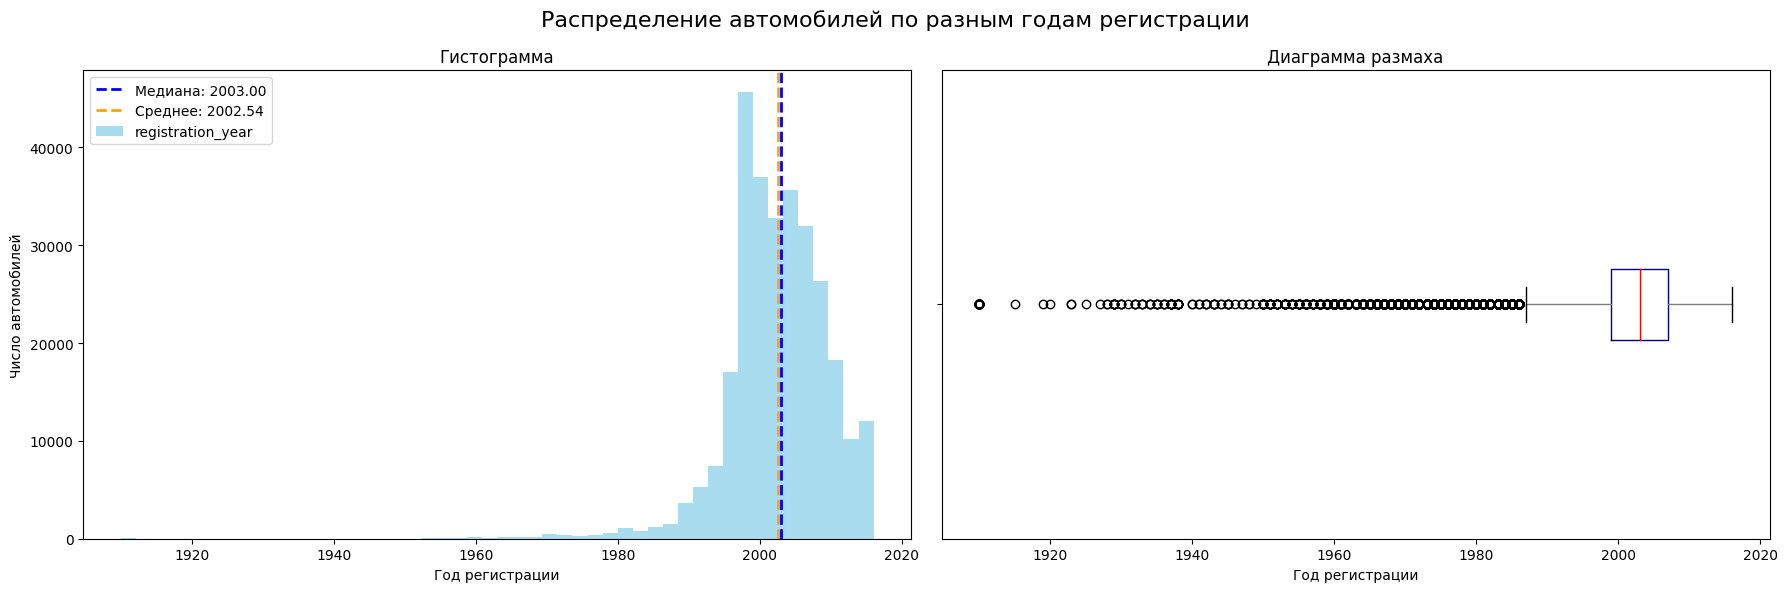

In [33]:
hist_and_box_chart('registration_year','Распределение автомобилей по разным годам регистрации', 'Число автомобилей', 'Год регистрации', 50)

In [34]:
autos.query('registration_year < 1980')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
15,450,small,1910,other,0,ka,5000,petrol,ford,unknown
340,10000,bus,1976,other,0,transporter,5000,petrol,volkswagen,unknown
504,4900,convertible,1973,manual,44,kaefer,90000,petrol,volkswagen,no
593,12000,sedan,1969,manual,140,s_klasse,80000,petrol,mercedes_benz,no
611,15000,coupe,1971,other,0,other,5000,petrol,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...
290472,200,other,1910,other,0,other,5000,petrol,sonstige_autos,unknown
290526,10500,convertible,1968,manual,54,other,20000,petrol,renault,no
290548,0,other,1970,other,0,sl,150000,petrol,mercedes_benz,unknown
290716,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes


- В среднем автомобилю на момент объявления было около 15 лет.
- Раритетные автомобили старше 1980 года - явление более чем реальное. Другое дело, что там ценообразование сильно отличается от рынка и является темой для отдельной модели. Лучше эти строки удалить. (Тем более, что их всего около 1%.)

In [35]:
#удалим старые авто
autos = autos.query('registration_year > 1980').copy()

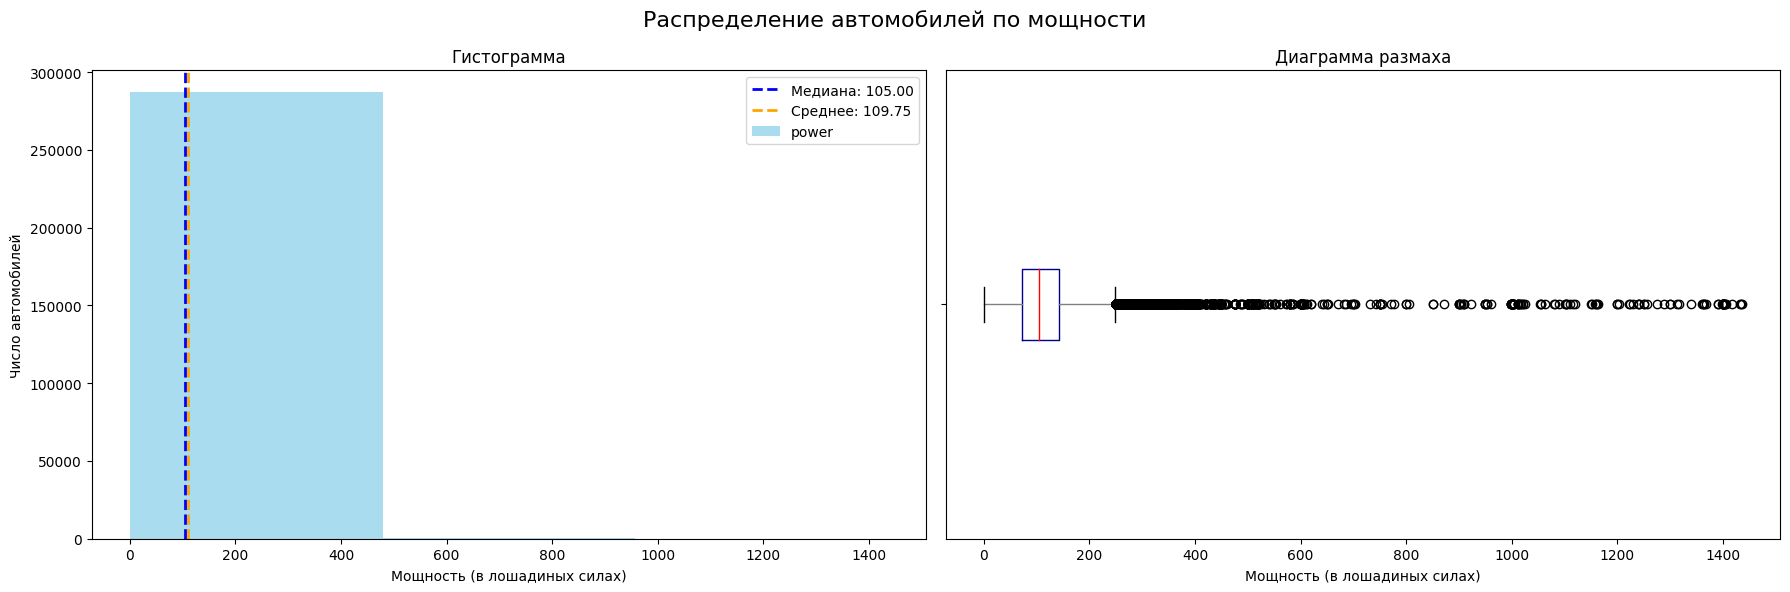

In [36]:
hist_and_box_chart('power','Распределение автомобилей по мощности', 'Число автомобилей', 'Мощность (в лошадиных силах)', 3)

In [37]:
autos.query('power < 30 & fuel_type != "electric"')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
0,480,other,1993,manual,0,golf,150000,petrol,volkswagen,unknown
30,245,sedan,1994,other,0,golf,150000,petrol,volkswagen,no
35,1500,other,2016,other,0,kangoo,150000,petrol,renault,no
38,0,other,1990,other,0,corsa,150000,petrol,opel,unknown
50,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
290752,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
290753,180,other,1995,other,0,other,125000,petrol,opel,unknown
290759,2600,other,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,unknown
290768,3999,wagon,2005,manual,3,3er,150000,petrol,bmw,no


In [38]:
autos.query('power > 500')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
1722,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
3847,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5022,500,wagon,1999,manual,1001,astra,150000,petrol,opel,unknown
5937,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes
6127,3000,small,2009,manual,771,punto,125000,petrol,fiat,unknown
...,...,...,...,...,...,...,...,...,...,...
284749,20000,other,2016,auto,507,m_reihe,150000,petrol,bmw,unknown
285371,450,sedan,1996,auto,1004,vectra,80000,petrol,opel,yes
286815,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
288975,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no


- Сейчас средняя мощность - около 110.
- Однако, в датасете около 10% вполне обычных автомобилей - не электрокаров и не раритетов (которые мы уже удалили) - имеют мощность ниже 30. Вероятно, такие значения являются ошибкой заполнения данных, а 0 и вовсе скорее аналог заглушки для NaN, поэтому мы просто заменим значения ниже 30 для не_электрокаров средним значением.
- Автомобили с мощностью выше 500 - явление реальное, но это отдельный класс люксовых автомобилей, с отличными правилами ценообразования. Если же говорить о массовом сегменте, то верхняя граница 500 вполне включает в себя даже пикапы с автобусами, поэтому ею мы и ограничимся. Остальные полпроцента удалим.

In [39]:
#удалим значения выше 500
autos = autos.query('power < 500').copy()
#заменим значения ниже 30 на среднее у не_электрокаров
power_limit_condition = (autos['power'] < 30) & (autos['fuel_type'] != 'electric')
autos.loc[power_limit_condition, 'power'] = 110

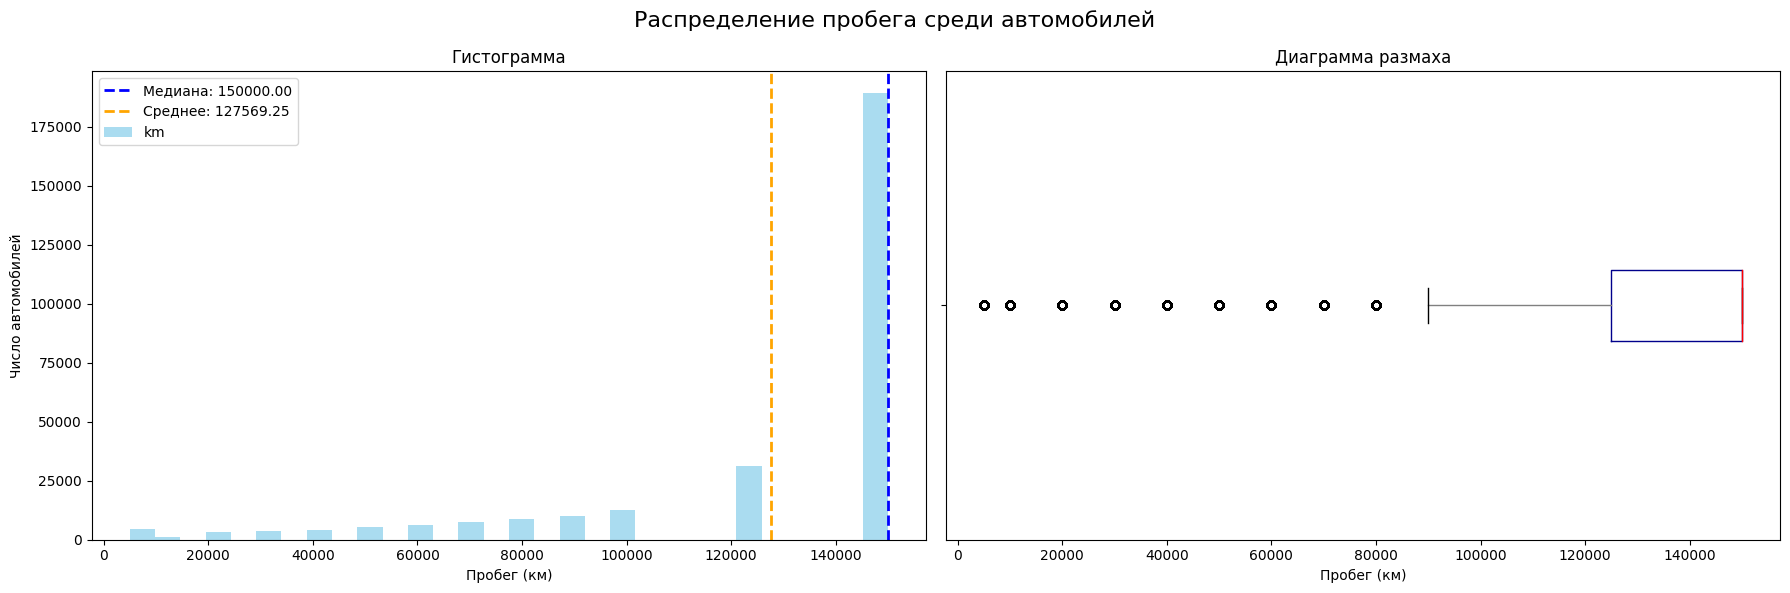

In [40]:
hist_and_box_chart('km','Распределение пробега среди автомобилей', 'Число автомобилей', 'Пробег (км)', 30)

In [41]:
autos.query('km < 15000')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
26,1990,bus,1981,manual,50,transporter,5000,petrol,volkswagen,no
48,1400,other,2016,manual,55,other,5000,petrol,hyundai,unknown
108,0,small,1999,other,110,other,5000,petrol,volkswagen,unknown
147,0,other,2006,other,110,other,5000,petrol,fiat,unknown
149,7500,suv,2007,auto,194,sorento,5000,petrol,kia,unknown
...,...,...,...,...,...,...,...,...,...,...
290250,550,other,1990,other,110,80,5000,petrol,audi,unknown
290353,2499,wagon,2002,auto,150,a6,5000,petrol,audi,yes
290561,10985,small,2015,manual,82,1_reihe,5000,petrol,peugeot,no
290615,0,other,2000,manual,55,punto,5000,petrol,fiat,yes


In [42]:
autos.query('km < 15000 & registration_year < 2015')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
26,1990,bus,1981,manual,50,transporter,5000,petrol,volkswagen,no
108,0,small,1999,other,110,other,5000,petrol,volkswagen,unknown
147,0,other,2006,other,110,other,5000,petrol,fiat,unknown
149,7500,suv,2007,auto,194,sorento,5000,petrol,kia,unknown
150,800,sedan,1993,manual,110,golf,10000,petrol,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...
290221,900,other,1995,manual,110,601,5000,petrol,trabant,unknown
290250,550,other,1990,other,110,80,5000,petrol,audi,unknown
290353,2499,wagon,2002,auto,150,a6,5000,petrol,audi,yes
290615,0,other,2000,manual,55,punto,5000,petrol,fiat,yes


- Среднее значение пробега - 127569 км.
- Около 10% имеют значения меньше нижней границы боксплота (около 90000 км), что в целом реально, но 1% имеет пробег меньше 15000 км, вплоть до 0. Ситуация этого 1% скорее реальна для машин не старше 2015 года или для "консервированного" раритета, который мы уже удалили. Поэтому такие выбросы мы заменим на среднее.

In [43]:
#заменим значения ниже 15000 на среднее у машин старше 2015
km_limit_condition = (autos['km'] < 15000) & (autos['registration_year'] > 2015)
autos.loc[km_limit_condition, 'km'] = 127500

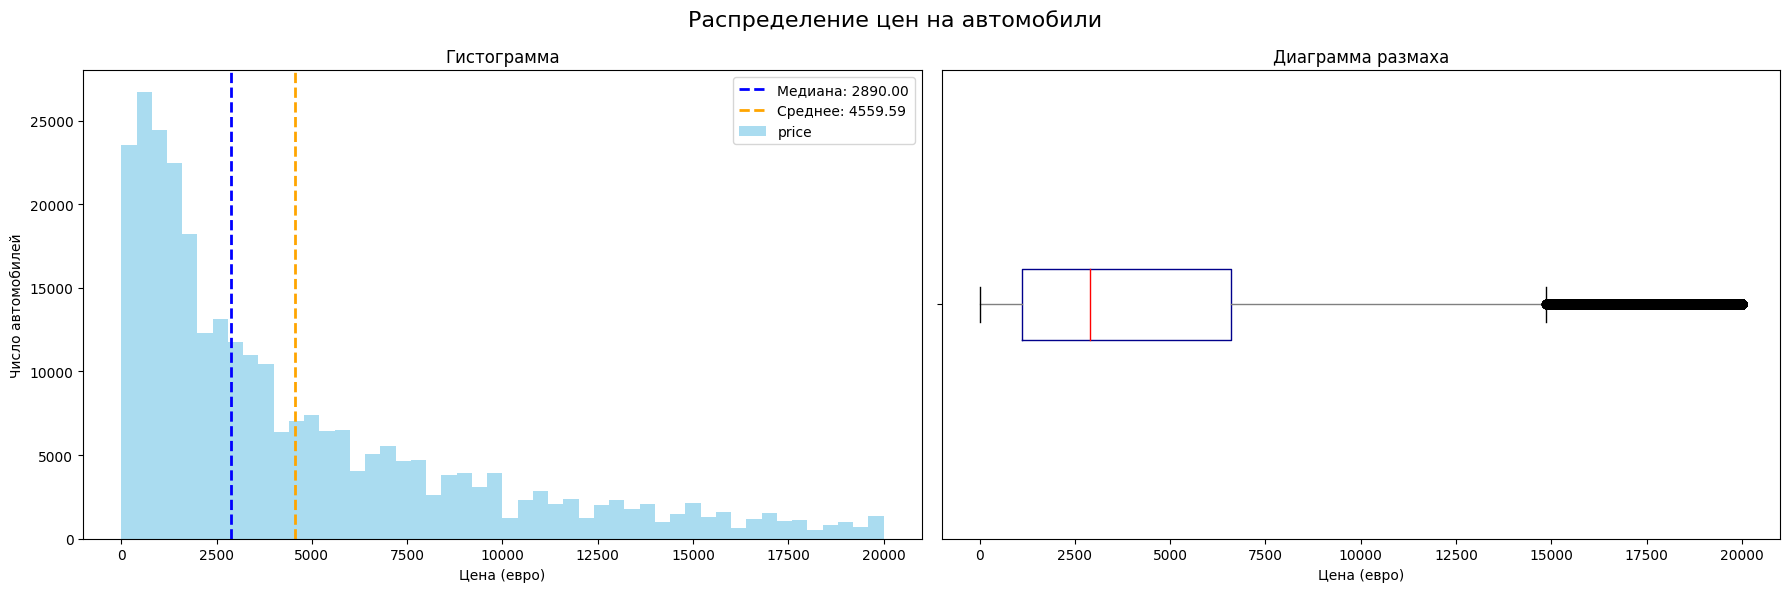

In [44]:
hist_and_box_chart('price','Распределение цен на автомобили', 'Число автомобилей', 'Цена (евро)', 50)

In [45]:
autos.query('price < 200')['price'].value_counts()

0      7382
150    1362
1       881
100     858
50      285
       ... 
181       1
27        1
33        1
38        1
162       1
Name: price, Length: 109, dtype: int64

In [46]:
autos.query('price < 200')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
38,0,other,1990,other,110,corsa,150000,petrol,opel,unknown
54,1,suv,1994,manual,286,other,150000,petrol,sonstige_autos,unknown
73,150,other,2016,manual,75,astra,150000,petrol,opel,yes
83,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
108,0,small,1999,other,110,other,5000,petrol,volkswagen,unknown
...,...,...,...,...,...,...,...,...,...,...
290707,150,small,1993,manual,55,astra,150000,petrol,opel,yes
290710,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
290732,99,small,1999,manual,60,arosa,150000,petrol,seat,yes
290753,180,other,1995,other,110,other,125000,petrol,opel,unknown


In [47]:
autos.query('price > 15000')

,price,vehicle_type,registration_year,gearbox,power,model,km,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,other,125000,petrol,audi,yes
14,17999,suv,2011,manual,190,navara,70000,petrol,nissan,no
31,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
163,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
170,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no
...,...,...,...,...,...,...,...,...,...,...
290634,15800,convertible,2002,manual,197,clk,90000,petrol,mercedes_benz,no
290640,15190,bus,2011,manual,140,touran,80000,petrol,volkswagen,no
290711,16500,suv,2013,manual,116,i_reihe,30000,petrol,hyundai,no
290730,16999,wagon,2008,auto,269,a6,150000,petrol,audi,no


- Среднее равно 4560 выше медианы почти на 2000 из-за длинного плавного хвоста в сторону высоких значений.
- Хотя высокие значения в целом реальны, реальны они скорее для тяжелого люкса с отличным от массы ценообразованием. В остальном это либо опечатка типа лишнего нуля/другая ошибка, либо неадекватные рынку чувства продавца к своей ласточке. Всё это может создать много искажений, лучше удалить.
- Более примечательна нижняя граница, которая формально аномалией не является. 2% датасета занимают бесплатные авто, и еще чуть меньше 2% - разные значения ниже 200, включая "символические" типа 1 евро и вовсе случайные. 0 выглядит скорее как аналог заглушки для NaN, а другие низкие значения могут быть чем угодно от опечатки (не хватает 0 в конце) до трюков по привлечению внимания и просто ошибок в заборе данных. Объем таких подозрительных данных не велик, поэтому для чистоты эксперимента их проще удалить.

In [48]:
autos = autos.query('price > 200 & price < 15000').copy()

In [49]:
#и, коль скоро мы повносили еще правочек, проверим всё еще раз на дубликаты и поправим индексацию
print('Число удаленных дубликатов после финальной проверки:', autos.duplicated().sum())
autos = autos.drop_duplicates()
autos = autos.reset_index(drop=True)

Число удаленных дубликатов после финальной проверки: 102


### Выводы по исследовательскому анализу данных

- **Качественные признаки выглядят правдоподобно**, нареканий не вызывают, имеются некоторые некритичные перекосы в данных.
- **В количественных признаках был выявлен и устранен ряд аномалий**, которые могли бы негативно повлиять на обучение и работу моделей.
  - Были удалены раритетные автомобили старше 1980 года, т.к. это отдельный немассовый рынок со своим ценообразованием.
  - Диапазон мощности двигателей был ограничен значениями от 30 до 500. Значения выше 500 были удалены, а значения ниже 30 были заменены на среднее. Исключение - электрокары, для которых были сохранены оригинальные низкие значения.
  - Нижняя граница пробега для автомобилей старше года была установлена от 15000 км. Значения пробега для автомобилей, которые не соответствовали этим критериям, были заменены на среднее значение.
  - Диапазон распределения цен был ограничен значениями от 200 до 15000 евро, чтобы избегать негативного влияния аномалий на обучение и работу моделей.

## Корреляционный анализ

### Матрица корреляции

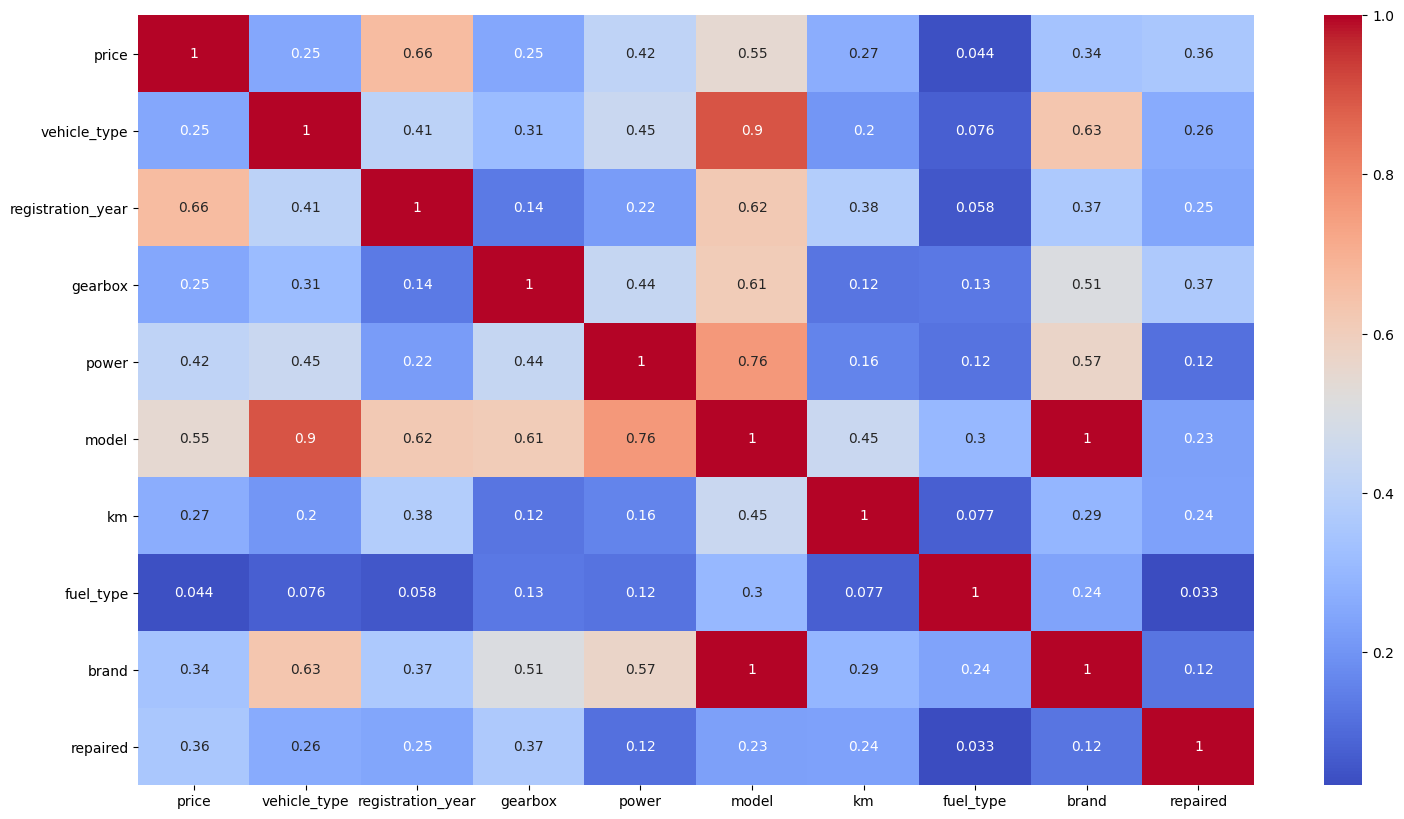

In [50]:
plt.figure(figsize=(18, 10))
#оценка руководителя по сути является ранговой переменной, поэтому в контексте вычисления корреляции признаков мы ее исключим из числа количественных
interval_cols = ['price', 'registration_year', 'power', 'km']
sns.heatmap(autos.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

- Сильнее всего цена коррелирует с годом и моделью.
- Самая низкая корреляция - с типом топлива. Вероятно, потому, что признак сам по себе не шибко информативен - почти всё ездит на бензине.
- Модель вполне ожидаемо сильно коррелирует со многими характеристиками, включая мультиколинеарность с брендом и типом двигателя.

### Выводы из корреляционного анализа

- Сильнее всего цена коррелирует с годом регистрации и моделью.
- Мультиколинеарность устранять пока не будем, т.к. потенциально она может быть сильно вредна только линейной модели - сначала посмотрим на результаты и на то, сколько их придется ждать из-за возможного замедления обучения.

## Модель предсказания цены

Создадим три модели прогноза стоимости автомобиля.
- Линейная регрессия
- LightGBM
- CatBoost

Критерии оценки моделей:
- Качество предсказания на тестовой выборке: RMSE < 2500
- Время обучения модели.
- Время предсказания модели.

### Линейная регрессия

In [51]:
#выделим целевой признак и входные данные
X = autos.drop('price', axis=1)
y = autos['price']

#разделим на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

#проверим размеренность
print('Размеренность датасета с входными данными:', X.shape[0], X.shape[1])
print('Размеренность датасета с тренеровочными данными:', X_train.shape[0], X_train.shape[1])
print('Размеренность датасета с валидационными данными:', X_val.shape[0], X_val.shape[1])
print('Размеренность датасета с тестовыми данными:', X_test.shape[0], X_test.shape[1])

Размеренность датасета с входными данными: 258755 9
Размеренность датасета с тренеровочными данными: 155253 9
Размеренность датасета с валидационными данными: 51751 9
Размеренность датасета с тестовыми данными: 51751 9


- Все столбцы на месте, число строк соответствует ожиданиям.

In [52]:
#чуть заморочимся с кодированием на входе
numerical_features = ['registration_year', 'power', 'km']
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

#категориальные признаки
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat_ohe = ohe_encoder.fit_transform(X_train[categorical_features])
X_val_cat_ohe = ohe_encoder.transform(X_val[categorical_features])
X_test_cat_ohe = ohe_encoder.transform(X_test[categorical_features])
ohe_feature_names = ohe_encoder.get_feature_names_out(categorical_features)

X_train_cat_ohe_pd = pd.DataFrame(X_train_cat_ohe, columns=ohe_feature_names, index=X_train.index)
X_val_cat_ohe_pd = pd.DataFrame(X_val_cat_ohe, columns=ohe_feature_names, index=X_val.index)
X_test_cat_ohe_pd = pd.DataFrame(X_test_cat_ohe, columns=ohe_feature_names, index=X_test.index)

#количественные признаки
scaler = MinMaxScaler()
X_train_num_scaled = scaler.fit_transform(X_train[numerical_features])
X_val_num_scaled = scaler.transform(X_val[numerical_features])
X_test_num_scaled = scaler.transform(X_test[numerical_features])

X_train_num_scaled_pd = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=X_train.index)
X_val_num_scaled_pd = pd.DataFrame(X_val_num_scaled, columns=numerical_features, index=X_val.index)
X_test_num_scaled_pd = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=X_test.index)

#финальный набор для модели
X_train_final = pd.concat([X_train_num_scaled_pd, X_train_cat_ohe_pd], axis=1)
X_val_final = pd.concat([X_val_num_scaled_pd, X_val_cat_ohe_pd], axis=1)
X_test_final = pd.concat([X_test_num_scaled_pd, X_test_cat_ohe_pd], axis=1)

#создадим и обучим модель линейной регрессии
start_time = time.time()

model_lr = LinearRegression()
model_lr.fit(X_train_final, y_train)

end_time_train = time.time()

#оценим время обучения линейной модели
training_time_lr = end_time_train - start_time
print("Время обучения LinearRegression: %s секунд" % training_time_lr)

#оценим время предсказания лнейной модели
start_time_predict = time.time()
val_predictions_lr = model_lr.predict(X_val_final)
end_time_predict = time.time()
prediction_time_lr = end_time_predict - start_time_predict
print("Время предсказания LinearRegression: %s секунд" % prediction_time_lr)

#оценим работу линейной модели
rmse_lr = root_mean_squared_error(y_val, val_predictions_lr)
print("RMSE LinearRegression на валидационной выборке: %.2f" % rmse_lr)

Время обучения LinearRegression: 2.6839497089385986 секунд
Время предсказания LinearRegression: 0.1004493236541748 секунд
RMSE LinearRegression на валидационной выборке: 2108.10


### LightGBM

In [53]:
#сделаем из категориальных переменных числовые
autos['vehicle_type'] = autos['vehicle_type'].astype('category').cat.codes
autos['gearbox'] = autos['gearbox'].astype('category').cat.codes
autos['model'] = autos['model'].astype('category').cat.codes
autos['fuel_type'] = autos['fuel_type'].astype('category').cat.codes
autos['brand'] = autos['brand'].astype('category').cat.codes
autos['repaired'] = autos['repaired'].astype('category').cat.codes
categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

#выделим целевой признак и входные данные
X = autos.drop('price', axis=1)
y = autos['price']

#разделим на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

#проверим размеренность
print('Размеренность датасета с входными данными:', X.shape[0], X.shape[1])
print('Размеренность датасета с тренеровочными данными:', X_train.shape[0], X_train.shape[1])
print('Размеренность датасета с валидационными данными:', X_val.shape[0], X_val.shape[1])
print('Размеренность датасета с тестовыми данными:', X_test.shape[0], X_test.shape[1])

Размеренность датасета с входными данными: 258755 9
Размеренность датасета с тренеровочными данными: 155253 9
Размеренность датасета с валидационными данными: 51751 9
Размеренность датасета с тестовыми данными: 51751 9


- Все столбцы на месте, число строк соответствует ожиданиям.

In [54]:
#создадим и обучим модель LightGBM
start_time = time.time()

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 25,
    'max_depth': 25,
    'learning_rate': 0.3,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_val = lgb.Dataset(X_val, y_val, categorical_feature=categorical_features)

model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round = 500,
                      valid_sets=[lgb_train, lgb_val],
                      callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])

end_time = time.time()

#оценим время обучения модели LightGBM
training_time_lgb = end_time - start_time
print("Время обучения LightGBM: %s секунд" % training_time_lgb)

#оценим время предсказания модели LightGBM
start_time = time.time()
y_pred_lgb = model_lgb.predict(X_val)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %s секунд" % prediction_time_lgb)

#оценим работу модели LightGBM на тестовой выборке
rmse_lgb = root_mean_squared_error(y_val, y_pred_lgb)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)


Время обучения LightGBM: 2.5060882568359375 секунд
Время предсказания LightGBM: 0.27764248847961426 секунд
RMSE LightGBM на валидационной выборке: 1378.83


### CatBoostRegressor

In [55]:
#создадим и обучичм модель CatBoostRegressor
start_time = time.time()

model_catboost = CatBoostRegressor(iterations=500,
                                   learning_rate=0.3,
                                   depth=10,
                                   loss_function='RMSE',
                                   random_state=RANDOM_STATE)

model_catboost.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False, early_stopping_rounds=50)

end_time = time.time()

#оценим время обучения модели CatBoostRegressor
training_time_catboost = end_time - start_time
print("Время обучения CatBoostRegressor: %s секунд" % training_time_catboost)

#оценим время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost = model_catboost.predict(X_val)
end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_catboost)

#оценим работу модели CatBoostRegressor на тестовой выборке
rmse_catboost = root_mean_squared_error(y_val, y_pred_catboost)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)


Время обучения CatBoostRegressor: 14.764887571334839 секунд
Время предсказания CatBoostRegressor: 0.05333232879638672 секунд
RMSE CatBoostRegressor на валидационной выборке: 1373.77


### Сравнительный анализ работы моделей

In [56]:
#соберем данные в табличку
models_comparison = pd.DataFrame({'Модель': ['Linear Regression', 'LightGBM', 'CatBoostRegressor'],
                        'Время обучения (сек)': [round(training_time_lr, 2), round(training_time_lgb, 2), round(training_time_catboost, 2)],
                        'Время предсказания (сек)': [round(prediction_time_lr, 2), round(prediction_time_lgb, 2), round(prediction_time_catboost, 2)],
                        'RMSE на тестовой выборке': [round(rmse_lr, 2), round(rmse_lgb, 2), round(rmse_catboost, 2)]})

models_comparison


,Модель,Время обучения (сек),Время предсказания (сек),RMSE на тестовой выборке
0,Linear Regression,2.68,0.10,2108.10
1,LightGBM,2.51,0.28,1378.83
2,CatBoostRegressor,14.76,0.05,1373.77


- Модель CatBoostRegressor имеет лучшее качество предсказания (RMSE=1373.77) и лучшее время предсказания (0.05). Хотя у нее значительно более длительное время обучения 14.92 секунд (в 6 раз дольше лучшего показателя), она сможет обеспечивать самый быстрый и точный результат для пользователей.
- Модель LightGBM является второй лучшей по качеству предсказания (с разницей ошибки в 5 евро по сравнению с CatBoostRegressor) и имеет лучшее время обучения 2.76 секунды. Однако, она имеет самое длительное время предсказания 0.29, что в 6 раз дольше, чем CatBoostRegressor. Если по каким-то причинам время обучения является более значимым критерием, чем время предсказания, то LightGBM является хорошей альтернативой CatBoostRegressor практически без потери качества.
- Все модели соответствуют заявленному порогу для RMSE - для всех моделей эта метрика меньше 2500.
- Все модели обеспечивают предсказание за время до 0.3 секунд.

In [57]:
#оценим время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost_on_test = model_catboost.predict(X_test)
end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor на тестовой выборке: %s секунд" % prediction_time_catboost)

#оценим работу модели CatBoostRegressor на тестовой выборке
rmse_catboost = root_mean_squared_error(y_test, y_pred_catboost_on_test)
print("RMSE CatBoostRegressor на тестовой выборке: %.2f" % rmse_catboost)

Время предсказания CatBoostRegressor на тестовой выборке: 0.05292057991027832 секунд
RMSE CatBoostRegressor на тестовой выборке: 1359.13


### Выводы по моделям предсказания цен

- Рекомендуемая для внедрения модель - CatBoostRegressor. У нее лучшее качество предсказаний и время предсказания.
- Вторая лучшая модель - LightGBM. Качество ее работы идентично CatBoostRegressor и она в 6 раз быстрее обучается, но и в 6 раз дольше выдает предсказание.
- Качество предсказаний всех трех моделей соответствует заявленному порогу RMSE < 2500 и обеспечивают предсказание за время до 0.35 сек.

## Общие выводы

**Ход проекта**

1. **Обзор и предобработка данных**
   - В ряде столбцов были устранены пробелы в количестве от 5 до 20% от общего числа строк. Пробелы заполнялись модой и новыми категориями, в зависимости от контекста данных. Столбцы с устраненными пробелами: тип кузова, коробка передач, модель, тип топлива, данные о починке.
   - Были внесены незначительные правки по запонению значений: устранены опечатки, смысловые повторы, переименованы столбцы.
   - Были устранены явные и неявные дубликаты.
   - Для более корректной и быстрой работы модели отказались от нерелевантных и/или неинформативных столбцов: дата забора анкет, дата публикации объявления, месяц регистрации авто, число фото, район проживания и момент последнего визита пользователя.
   - Были удалены данные с явными аномалиями по дате регистрации и мощности автомобилей. 
2. **Исследовательский анализ данных**
   - Категориальные признаки значительных нареканий не вызывают.
   - В количественных признаках был выявлен и устранен ряд аномалий, которые могли бы негативно повлиять на обучение и работу моделей.
     - Были удалены раритетные автомобили старше 1980 года, т.к. это отдельный немассовый рынок со своим ценообразованием.
     - Диапазон мощности двигателей был ограничен значениями от 30 до 500. Значения выше 500 были удалены, а значения ниже 30 были заменены на среднее. Исключение - электрокары, для которых были сохранены оригинальные низкие значения.
     - Нижняя граница пробега для автомобилей старше года была установлена от 15000 км. Значения пробега для автомобилей, которые не соответствовали этим критериям, были заменены на среднее значение.
     - Диапазон распределения цен был ограничен значениями от 200 до 15000 евро, чтобы избегать негативного влияния аномалий на обучение и работу моделей.
3. **Корреляционный анализ**
   - Сильнее всего цена коррелирует с годом регистрации и моделью.
   - Менее всего цена коррелирует с типом топлива (однако, это актуально конкретно для данного датасета, т.к. почти все авто ездят на бензине, что не соответствует современным реалиям).
4. **Обучение нескольких моделей предсказания цены**
   - Рекомендуемая для внедрения модель - CatBoostRegressor. Параметры лучшей модели: время обучения 14.69 секунд; время предсказания на валидационной и на тестовой одинаковое и равно 0.05 секунд; RMSE на валидационной выборке 1373.77 и на тестовой 1359.13. 
   - Вторая лучшая модель - LightGBM. Параметры второй лучшей модели: RMSE = 1378.21, время предсказания 0.34 секунды, время обучения 2.43 секунды.
   - Модель линейной регрессии хорошо показывает себя в части скорости обучения и предсказания, но значительно уступает в качестве. Параметры модели линейной регрессии: RMSE = 2123.33, время предсказания 0.1 секунды, время обучения 2.65 секунды.
   - Качество предсказаний всех трех моделей соответствует заявленному порогу RMSE < 2500 и обеспечивают предсказание за время до 0.35 сек.
_______________________

**Дополнительные рекомендации**

**Улучшение процесса сбора данных**
- Ряд колонок не учитывает особенности современных автомобилей, таких как тип коробки передач или тип кузова.
- Дополнительная информация помогла бы улучшить качество работы моделей. Например, цвет автомобиля, объем двигателя, история дтп, состояние шин и т.д.
- Данные содержат много информации по устаревшим моделям (даже на 2016 год), неактуальным в 2025 году, что сказывается на качестве предсказания. Поэтому рекомендуется доработка моделей на более свежих данных.

**Модели предсказания цены для отдельных сегментов**
- Ряд сегментов имеет отличное ценообразование от масс-маркета: раритетные авто, люксовые автомобили, гоночные автомобили. Для таких сегментов рынка рекомендуются отдельные предсказательные системы.
